In [1]:
# Auto Regressive Ingerated Moving Average
# Time series can be broken into 3 components
# Trend, Seasonality and Noise

In [2]:
# Stationary data requirements
# The mean should not be function of time
# The variance should be static (homoscedasticity)
# The covariance should not be function of time

In [24]:
# imports
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
# register_matplotlib_converters()
# it makes sure that pandas datatypes like 
# pd.Timestamp can be used in matplotlib plots 
# without having to cast them to another type.

In [5]:
dataset = pd.read_csv('Air_Traffic_SanFrancisco.csv')

In [6]:
dataset.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,Adjusted Activity Type Code,Adjusted Passenger Count,Year,Month
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271,Deplaned,27271,2005,July
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131,Enplaned,29131,2005,July
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415,Thru / Transit * 2,10830,2005,July
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156,Deplaned,35156,2005,July
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090,Enplaned,34090,2005,July


In [7]:
# We have this dataset, but it has too much information
# compared to what we want. We would regroup the dataset
# first by year and then by month and would sum total
# Adjusted Passenger Counts
# So our dataset would should number of passengers in
# the air for every month across years

In [8]:
dataset = dataset.rename(columns = {"GEO Summary": "GEO_Summary"})
dataset = dataset[dataset['GEO_Summary'] == 'Domestic']

In [9]:
df = dataset.groupby(['Year','Month'])['Adjusted Passenger Count'].sum()

In [10]:
date = []
for x in range(0,df.index.shape[0]):
    dt = F"01-{df.index[x][1]}-{df.index[x][0]}"
    date.append(dt)

In [12]:
df.index = date
df.index = pd.to_datetime(df.index)
df = df/1000000   #To represent number of people in millions

In [13]:
df.head()

2005-08-01    2.425779
2005-12-01    2.021058
2005-07-01    2.446383
2005-11-01    2.013012
2005-10-01    2.113786
Name: Adjusted Passenger Count, dtype: float64

<AxesSubplot:>

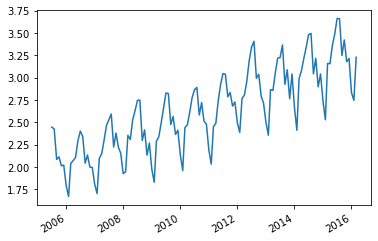

In [23]:
df.plot()

In [15]:
# The first task is to determine if the series is
# stationary or not
# there are two ways to check for that
# 1 - Rolling Statistics: Plot rolling mean and rolling
# standard deviation and check if they are constant with
# time
# 2 - Augmented Dickey-Fuller Test: The series is considered
# Stationary if p-value is low. The Null hypothesis is
# that the series is not stationary

In [38]:
# Lets start by Rolling average and mean
rol_mean = df.rolling(window = 12).mean()
rol_std = df.rolling(window = 12).std()

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

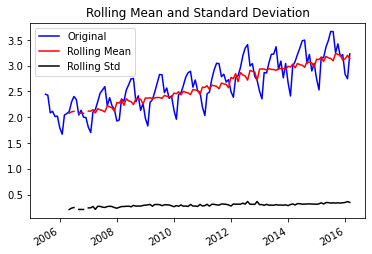

In [50]:
df.plot(color = 'blue', label = 'Original', legend=True)
rol_mean.plot(color = 'red', label = 'Rolling Mean', legend=True)
rol_std.plot(color = 'black', label = 'Rolling Std', legend=True)
plt.title('Rolling Mean and Standard Deviation')

In [40]:
# As seen from the graph above, standard deviation is
# almost constant but the mean is increasing, hence the
# time series is not stationary

In [48]:
# Now performing ADF test
result = adfuller(df)
# lets write a function based on null and alternate
# hypothesis for ADF test
def ADF_test(result):
    # H0: The series is not stationary
    # HA: The series is stationary
    if result[1] < 0.05:
        print(f"The series is stationary. P-value: {result[1]}")
    else:
        print(f"The series is not stationary. P-value: {result[1]}")
        
ADF_test(result)

The series is not stationary. P-value: 0.8562753807448935


In [49]:
# The time series is not stationary by ADF test.
# Hence we conclude time series is not stationary and
# move on to stabilize it

In [58]:
# Since we now need to try different functions to 
# stabilize timeseries, we need write a function
# that outputs the plot of the graph of original data,
# mean and standard deviation alongside results of
# Augmented Dickey-Fuller Test

def analyze_series(df):
    # rolling statistics
    rol_mean = df.rolling(window=12).mean()
    rol_std = df.rolling(window=12).std()
    
    # plotting results
    df.plot(color = 'blue', label = 'Original', legend=True)
    rol_mean.plot(color = 'red', label = 'Rolling Mean', legend=True)
    rol_std.plot(color = 'black', label = 'Rolling Std', legend=True)
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
        
    # performing adf test
    result = adfuller(df)
    
    return ADF_test(result)  

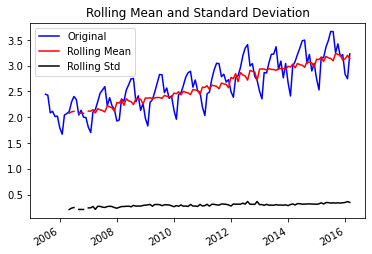

The series is not stationary. P-value: 0.8562753807448935


In [59]:
analyze_series(df)

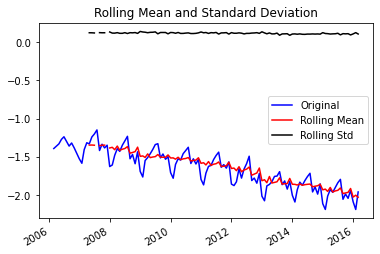

The series is not stationary. P-value: 0.9863635715446423


In [65]:
# Everything is perfect, Now its start to stabilize series
# lets try by subtract the rolling mean from log of series
df_log_mean = np.log(df) - df.rolling(window=12).mean()
df_log_mean.dropna(inplace=True)
analyze_series(df_log_mean)

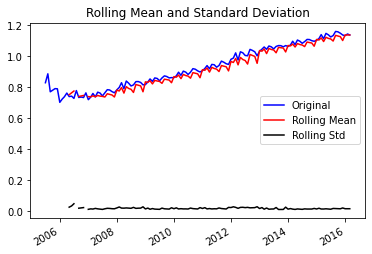

The series is not stationary. P-value: 0.11461287330735026


In [76]:
# lets try apply exponential decay to transform a time
# series
df_exp = np.log(df).ewm(halflife=6, min_periods=0, adjust=True).mean()
df_exp.dropna(inplace=True)
analyze_series(df_exp) 

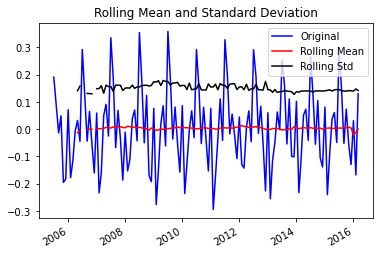

The series is stationary. P-value: 3.8734614502407244e-07


In [77]:
df_log_shift = np.log(df) - np.log(df).shift()
df_log_shift.dropna(inplace=True)
analyze_series(df_log_shift)

In [78]:
# Shifting has performed best for our case and we
# would go with it